## Introduction

Semantic segmentation is a process that takes an input image and returns an output image of the same size where each pixel belongs to a particular class of objects, not distinguishing between objects within a class.
For this study, the resulting image is binary, true meaning that a pixel is part of the class we are trying to segment and false meaning a pixel is not part of the class.

The purpose of this project was to compare different methods to use satellite data to segment roads. Three machine learning methodologies were used and each had increasing complexity and computational demands. These methods were K-Means Clustering, Random Forests, and Deep Learning using the UNet architecture. K-Means clustering is an unsupervised machine learning algorithm that partitions the data in k clusters, where k is determined by the user based on how many categories you want to cluster. It iteratively updates the centroids of each cluster using mean coordinates until convergence is achieved. Random forest classification is an ensemble learning method involving many decision trees. Each decision tree is trained on a random subset of observations and features, and predictions of the random forest are based on a plurality vote of the decision trees. The UNet architecture for deep neural networks was used as the final method. UNet consists of two convolutional neural networks put together: an encoder and a decoder. The encoder analyzes and extracts features and important information from the input image and the decoder takes this information and generates the binary segmentation image.

Each method was implemented and trained, if necessary, and then segmentation metrics were tested to see how well each method was performing. The metrics used were precision, recall, and Dice Coefficient. 
In addition to comparing the performance of each method, we discuss the computational power, training data, and time needed in order to implement them. 
The dataset used was [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset), which consists of 1110 training, 14 validation, and 49 testing satellite image and label pairs. Each image is 1500 by 1500 pixels at 1 meter resolution, resulting in each imaging capturing 2.25 square kilometers.

This report is a summary of our work, and does not include all code.
In particular, training the U-Net model required substantial computational effort and we did not re-run the entire model in this notebook.
For full documentation of our work, please visit our [GitHub repository](https://github.com/Liam-W-Smith/csci-0452-final-project/).

## Methods

### Packages and Functions
Before thoroughly describing our work, we import necessary packages and define a few functions.

In [2]:
# Import packages
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skm
import skimage.draw as draw
from skimage.color import rgb2gray
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter, gaussian_laplace
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import tensorflow.keras.backend as K
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.random import sample_without_replacement
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import median_filter

In [3]:
# Function to compute DICE
smooth=1
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
        
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    # DICE
    dice = dice_coef(y_true, y_pred)


    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3),
            "\nRecall", np.round(prec, 3), "\nDICE:", np.round(dice, 3))

# Function to create input layer
def classify_gray(image):

    # Compute the standard deviation of the r, g, and b channels
    std_dev = np.std(image, axis = 2)

    # Define a threshold for classifying gray pixels
    diff_threshold = 6 # Adjust as needed

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = std_dev < diff_threshold
        
    return gray_mask
    
# Function to compute layers for additional model features
def compute_features(img, include_categorical = True):    
    # Range of values (gray pixels will have low range)
    r = img.max(axis = 2) - img.min(axis = 2)

    if include_categorical:
        
        # Canny edge detection
        canny_edges_r = feature.canny(img[:,:,0], sigma=4)
        canny_edges_g = feature.canny(img[:,:,1], sigma=4)
        canny_edges_b = feature.canny(img[:,:,2], sigma=4)

         # Calculation Canny gradient
        image_gray = rgb2gray(img)
        canny_edges = feature.canny(image_gray, sigma=3)
    
        # Create disk
        disk = skm.disk(1)
    
        # Area closing for hough lines
        closed_edges = skm.dilation(canny_edges, footprint = disk)
        closed_edges = closed_edges * 255
    
        lines = transform.probabilistic_hough_line(closed_edges, threshold=5, line_length=25, line_gap=3)
        hough_lines = np.zeros(image_gray.shape, dtype=np.uint8)
    
        # Draw the detected lines on the canvas
        for line in lines:
            p0, p1 = line
            # Draw line segment
            rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
            hough_lines[rr, cc] = 255  # Set the pixel values to white (255) along the line
    
        #create gray mask
        gray_mask = classify_gray(img)
        gray_mask = gray_mask.reshape((img.shape[0], img.shape[1]))
    

        img = np.dstack([img, canny_edges_r, canny_edges_g, canny_edges_b, gray_mask, hough_lines])
        
    
    # Gaussian blur sigma = 1
    gaus_r_1 = gaussian_filter(img[:,:,0], sigma = 1)
    gaus_g_1 = gaussian_filter(img[:,:,1], sigma = 1)
    gaus_b_1 = gaussian_filter(img[:,:,2], sigma = 1)
    
    # Gaussian blur sigma = 3
    gaus_r_3 = gaussian_filter(img[:,:,0], sigma = 3)
    gaus_g_3 = gaussian_filter(img[:,:,1], sigma = 3)
    gaus_b_3 = gaussian_filter(img[:,:,2], sigma = 3)

    # Gaussian blur sigma = 5
    gaus_r_5 = gaussian_filter(img[:,:,0], sigma = 5)
    gaus_g_5 = gaussian_filter(img[:,:,1], sigma = 5)
    gaus_b_5 = gaussian_filter(img[:,:,2], sigma = 5)
    
    # LoG blur sigma = .5
    log_r_5 = gaussian_laplace(img[:,:,0], sigma = .5)
    log_g_5 = gaussian_laplace(img[:,:,1], sigma = .5)
    log_b_5 = gaussian_laplace(img[:,:,2], sigma = .5)
    
    # LoG blur sigma = .6
    log_r_6 = gaussian_laplace(img[:,:,0], sigma = .6)
    log_g_6 = gaussian_laplace(img[:,:,1], sigma = .6)
    log_b_6 = gaussian_laplace(img[:,:,2], sigma = .6)
    
    # LoG blur sigma = .8
    log_r_8 = gaussian_laplace(img[:,:,0], sigma = .8)
    log_g_8 = gaussian_laplace(img[:,:,1], sigma = .8)
    log_b_8 = gaussian_laplace(img[:,:,2], sigma = .8)
    
    # Add layers to model
    return np.dstack([img, r,
                     gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                     gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                     log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

def identify_road_cluster(clustered_image, image_label):

    cluster_labels = np.unique(clustered_image)

    best_recall = 0
    best_cluster = -1

    for i in cluster_labels:
        cluster = (clustered_image==i)
        C = confusion_matrix(image_label.ravel(), cluster.ravel(), labels=(True, False))

        # # Overall accuracy rate
        # acc = (C[0,0] + C[1,1])/C.sum()
        # # Recall
        recall = (C[0,0])/(C[0,0] + C[1,0])
        # Precision
        # prec = (C[0,0])/(C[0,0] + C[0,1])

        if recall > best_recall:
            best_recall = recall
            best_cluster = i

    return best_cluster

### Import Images

First, we import the images that we will use for most of our work.
For the k-means and random forest sections, we use one image for training and another for testing, so we display those images here.

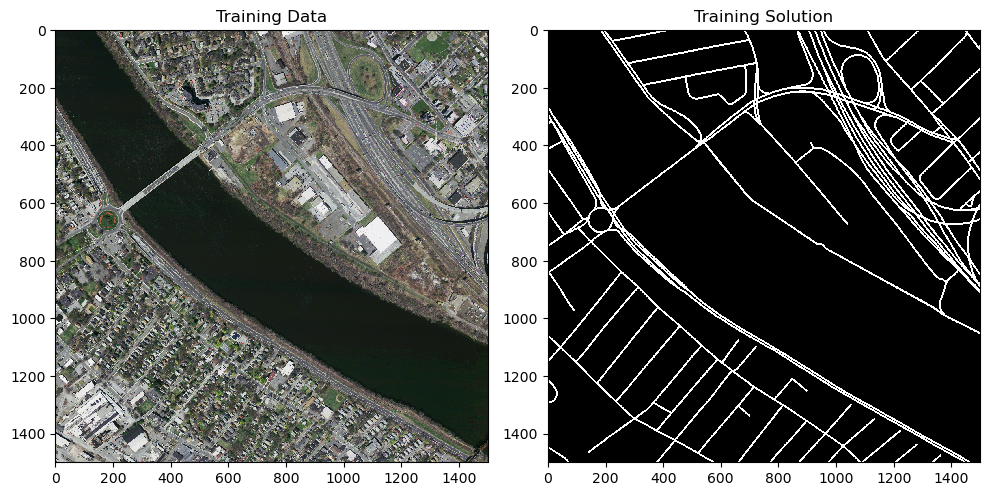

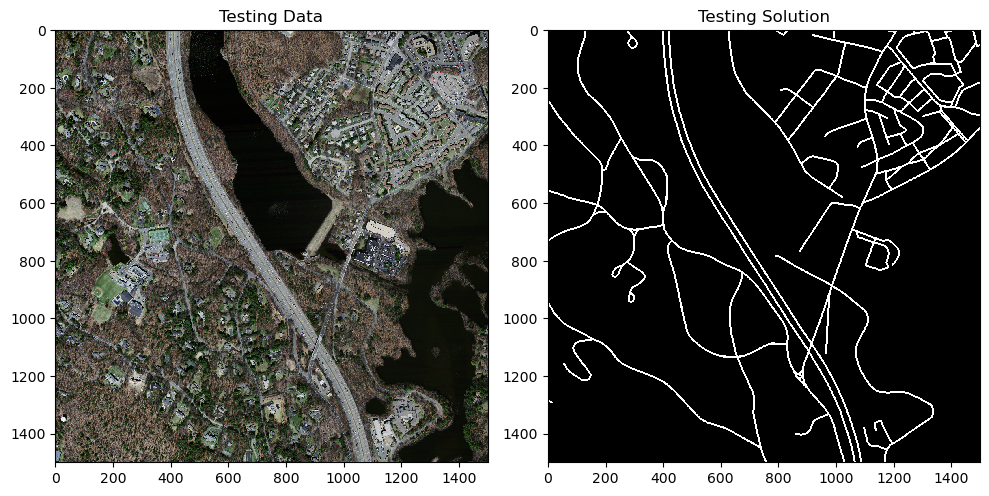

In [10]:
# Read the data
rgb = skio.imread("../data/MA_roads/tiff/train/10828735_15.tiff")
ans = skio.imread("../data/MA_roads/tiff/train_labels/10828735_15.tif") > 0

rgb_test = skio.imread("../data/MA_roads/tiff/train/21929005_15.tiff")
ans_test = skio.imread("../data/MA_roads/tiff/train_labels/21929005_15.tif") > 0

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Training Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Training Solution");

# Display testing data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Data")
skio.imshow(ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

### Creating Image Filters

In our k-means and random forest sections, we will compute many features to help identify specific aspects of roads.
In the previous section, we defined a function for creating this features.
Let us take a closer look at a smaller area and then apply our filters to that area.

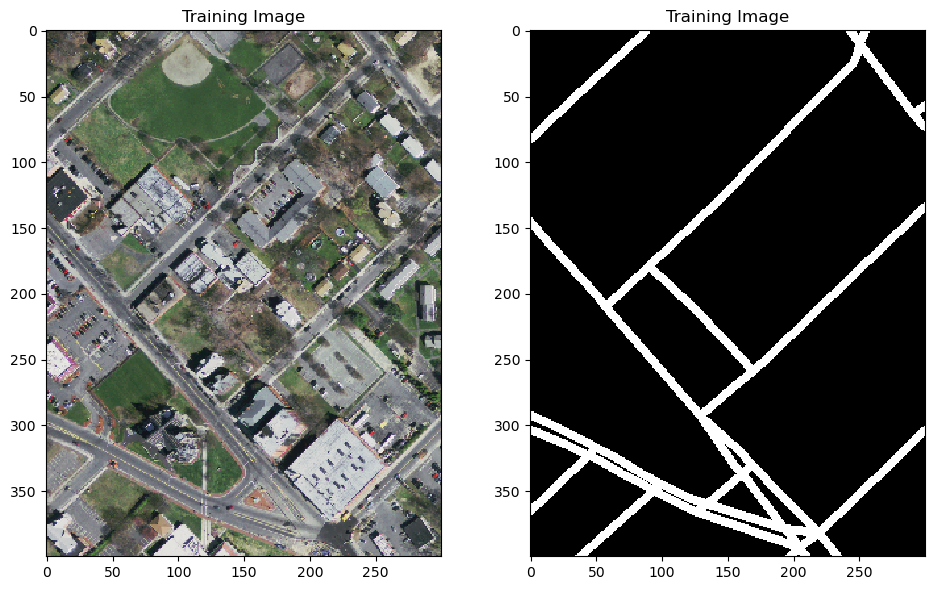

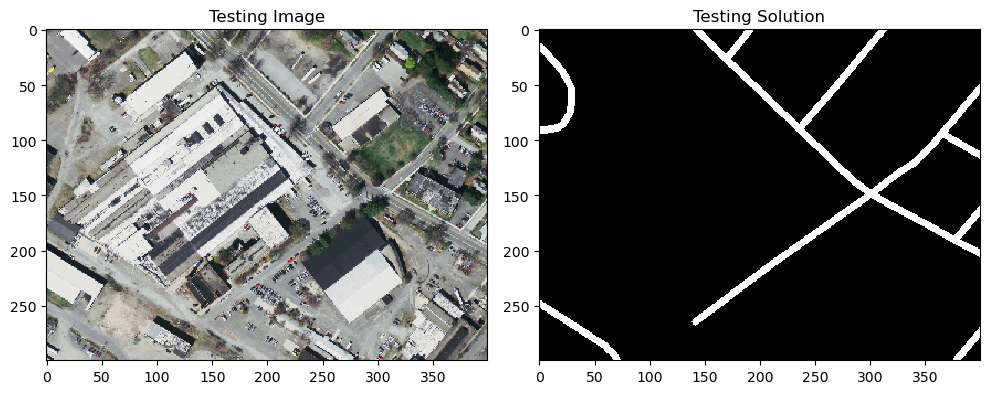

In [14]:
# Create training subset of data
small_rgb = rgb[0:400, 1200:, :]
small_ans = ans[0:400, 1200:]

# Create testing subset of data
small_rgb_test = rgb[1200:, 0:400, :]
small_ans_test = ans[1200:, 0:400]

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb, ax = ax[0])
ax[0].set_title("Training Image")
skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Training Image");

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

Now let us create and inspect our features.

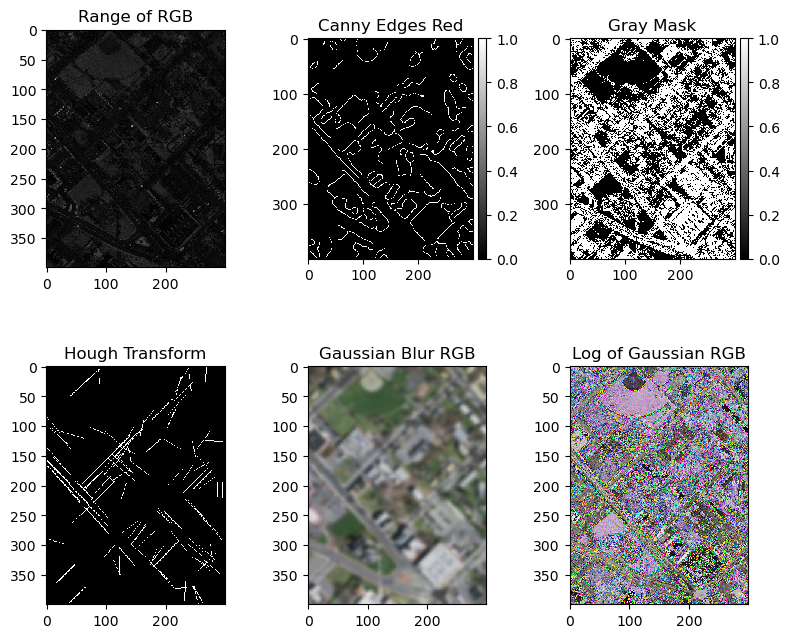

In [15]:
# Create features
small_rgb_layers = compute_features(small_rgb)

# Inspect features
fig, ax = plt.subplots(2, 3, figsize = (8, 8))
skio.imshow(small_rgb_layers[:,:,8], ax = ax[0,0])
ax[0,0].set_title("Range of RGB")
skio.imshow(small_rgb_layers[:,:,3], cmap = "gray", ax = ax[0,1])
ax[0,1].set_title("Canny Edges Red")
skio.imshow(small_rgb_layers[:,:,6], cmap = "gray", ax = ax[0,2])
ax[0,2].set_title("Gray Mask")
skio.imshow(small_rgb_layers[:,:,7], cmap = "gray", ax = ax[1,0])
ax[1,0].set_title("Hough Transform")
skio.imshow(small_rgb_layers[:,:,12:15], ax = ax[1,1])
ax[1,1].set_title("Gaussian Blur RGB")
skio.imshow(small_rgb_layers[:,:,18:21], ax = ax[1,2])
ax[1,2].set_title("Log of Gaussian RGB");

On the top left is the range of red, green and blue for each pixel.
We chose this feature because roads are gray, and in the RGB color space, gray pixels have similar values of red, green and blue.

On the top middle is canny edges for the red channel.
We created this feature hoping to detect the edges of roads, but as you can see, it detects edges in many objects other than roads.
We include canny edges in the red, green and blue channels.

On the top right is the graymask created using standard deviation amongst the RGB channels and a threshold.
It captures the roads, but also many other features.

On the bottom left is the hough transform image, which captures the long linear nature of roads but does not successfully detect every pixel.

On the bottom middle is the original image after gaussian blurring with $\sigma = 3$.
Our thought process here was that there might be some noise in the image leading random pixels to have the same R, G, and B values as roads.
By blurring the image, we hoped to account for this by giving some weight to the values of nearby pixels.
We include gaussian blur with $\sigma = 1$, $\sigma = 3$, and $\sigma = 5$ for red, green and blue, hoping that our model might learn from multiple blurring radii.

On the bottom right is our image after the log of gaussian filter has been applied to the red, green and blue channels.
We hopes to pick up on the width/frequency of roads with this filter, so we included this filter for $\sigma = 0.5$, $\sigma = 0.6$, and $\sigma = 0.8$.

### Principle Components Analysis

Principal Component Analysis (PCA) was utilized to assess the possibility of cutting down on the number of features input into the various models. Currently there are about 27 filtered and calculated features extracted from each 1500x1500x3 RGB image. When scaling this process, the ability to cut down on preprocessing steps and decrease the size of the image input into the models would provide large increases in the speed and storage needed to run this process. This is where PCA has the potential to help, PCA is a commonly used tool for dimensionality reduction across data science. PCA is especially helpful when a dataset has multiple potentially correlated and redundant features and it is unclear which features are most important. In this situation, many of the features generated from our satellite images may provide very similar information or are highly correlated. PCA would allow us to use less layers while retaining the maximum amount of variance. 

### K-Means Clustering

K-Means Clustering is a basic unsupervised machine learning algorithm that groups data points into k clusters, the value of k can be chosen by the user. The centroids of each cluster are initialized randomly as three data points and all points are assigned to the cluster nearest to them. Then the mean coordinates of all the points in each cluster is calculated and this value is now the new centroid for that cluster. Then the process is repeated until a maximum number of interactions is reached or the centroids spot changing significantly between each interaction. Although there were only two categories in this study; road and background, k was chosen to be three. This is because it was found by (Maurya, et al) to keep the clusters containing the roads from including other non-road features. 

K-Means clustering was run on features extracted from the full 1500x1500 images, and two sets of features were used. First was all features discussed in the previous section and the second was the top 5 principle components accessed by PCA. We will compare the results of these two approaches to K-Means clustering and then compare the results of K-Means in general to the results from our other models.


### Random Forest

Random forest is a highly flexible supervised machine learning algorithm that can perform both regression and classificiation and can take both continuous and categorical data as input.
Random forest is an ensemble learning method that works by training a specified number of decision trees on the training data.
Each [decision tree](https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/) is trained using a random subset of training data and features, and essentially is composed of a root node and a number of internal/decision nodes.
Each data point is passed to the root of the decision tree, and at each decision node, either travels to the node's left or right child depending on the value of one feature of the data point.
The data point is passed through the tree until it reaches a terminal node, at which point it is classified or given a predicted value.

In the [random forest model](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/), classification predictions are created based on a majority vote of the decision trees, while regression predictions are created based on averaging the output of the decision trees.
For our work, we consider each pixel as an observation and we use the random forest model to classify pixels as either road or non-road.
Due to computational constraints, we did not train a model using the entirety of multiple images -- we don't even train a model on a single image.
Each image has $2,250,000$ pixels, and we ran this part of our analysis on our personal computers.
Instead, we created our first model by training on the RGB channels of a subset of one image.
In the second model, we trained on the RBG channels plus all of the additional layers mentioned above.
We noticed that our model tended to produce far more accurate predictions on non-road pixels than road pixels, so we then sampled an image for an equal number of pixels of each class and trained both RGB and additional layer models on that input.
Then, we attempted to prevent overfitting by fitting a random forest on the additional layers input reduced to 5 features via PCA.
Finally, we trained both RGB and additional layers models on sampled data from multiple images.
In the results section, we compare the performance of all of our models.

### U-Net

A U-Net model is a convolutional neural network architecture which is designed for segmentation. The architecture is characterized by it’s symmetrical “U-shaped” design composed of an encoder path and a decoder path. The encoder path takes as input the original image and consists of multiple iterations of convolutional layers followed by max pooling layers. This path is designed to take the context and identify key features and reduce the spatial dimensions between each layer. The decoder path is unique to U-Net neural networks, as it attempts to construct a mask using the features learned in the encoder path and regaining the spatial dimensions lost. It consists of a series of up-sampling layers (often using transposed convolutions or interpolation) followed by concatenation with feature maps from the corresponding contracting path. Throughout this process, a skip connection is made between each layer of the two paths to preserve the high resolution between each layer. The final layer of the U-Net typically uses a 1x1 convolution followed by an activation function (e.g., sigmoid or softmax) to produce the final segmentation mask or output. This layer condenses the information learned by the network into the desired output format, such as a binary mask for semantic segmentation tasks.

Our U-Net model is comprised of 10 layers: 5 encoding layers and 5 decoding layers. We were limited by resources like time and memory, so instead of fitting the model with 1500 x 1500 pixel images, we used 128 x128 pixels. We also divided each 1500 x 1500 into 128 x 128 images, increasing the training size tremendously. Images and masks without roads were removed from the dataset. The model is optimized using the Adam algorithm with a learning rate of 0.01. Our loss is calculated using the Binary Cross-Entropy function. Like previous models, we measured the strength of our model using the dice coefficient. 


## Results

### PCA

Read in our PCA example image and label and crop them

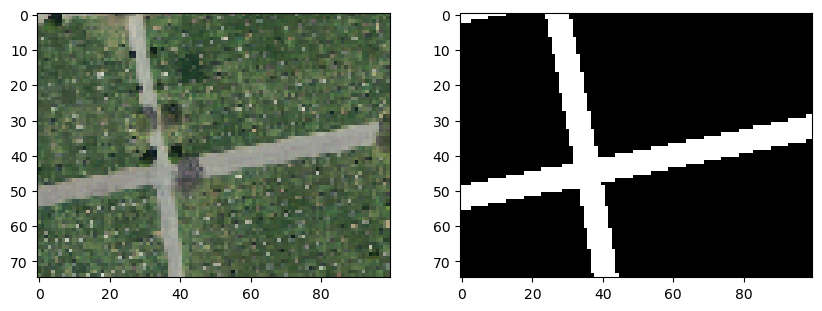

In [17]:
pca_img = skio.imread("../data/MA_roads/tiff/train/10528735_15.tiff")
pca_img_label = skio.imread("../data/MA_roads/tiff/train_labels/10528735_15.tif")

x1, x2 = 1200, 1300
y1, y2 = 300, 375
pca_img_cropped = pca_img[y1:y2, x1:x2, :]
pca_img_label_cropped = pca_img_label[y1:y2, x1:x2]

fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(pca_img_cropped)
axes[1].imshow(pca_img_label_cropped, cmap='gray')

plt.show()

This image will be used to demostrate what is being done with PCA and to assess how well the dimension reduction and variance maximization of PCA group of road points and background points into distnguishable clusters. A much smaller image is used so that the data points don't just appear as a large mass of the size of graph that is able to be shown. For this example, we picked a straight forward patch with a perpedicular road intersection.

Get all filters of the image

In [18]:
pca_filters = compute_features(pca_img_cropped)

Show top 5 principle components

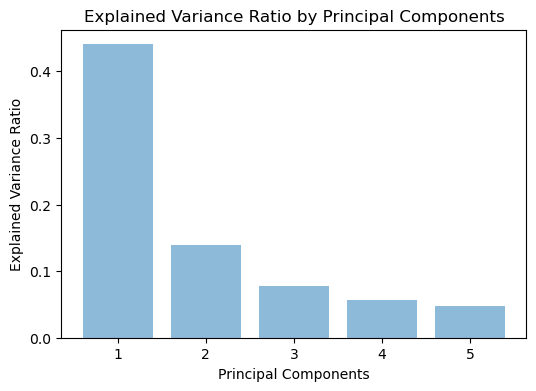

In [19]:
pca_layers = pca_filters.reshape(pca_filters.shape[0] * pca_filters.shape[1], pca_filters.shape[2])
# Standardize the features
scaler = StandardScaler()
pca_layers_scaled = scaler.fit_transform(pca_layers)

# Initialize PCA and fit the scaled data
pca_5 = PCA(n_components=5)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
pca_5_comps = pca_5.fit_transform(pca_layers_scaled)

# Explained variance ratio
explained_variance_ratio_5 = pca_5.explained_variance_ratio_

# Plotting the explained variance ratio
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio_5) + 1), explained_variance_ratio_5, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

This graph shows the percent of variance explained by the top 5 principle components, it can be interpretted that since the top component explains about 45% of variance, the second component explains about 15%, and so on. Therefore, in reducing our dimensions to just 5 we still maintain around 70-80% of the variance that our previous 27 features had.

In order to visualize the new dimensinos that PCA can output, we will use the top 3 components to plot our road and background points in 3D space

In [20]:
# Initialize PCA and fit the scaled data
pca_3 = PCA(n_components=3)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
pca_3_comps = pca_3.fit_transform(pca_layers_scaled)

Display labelled data points in 3D

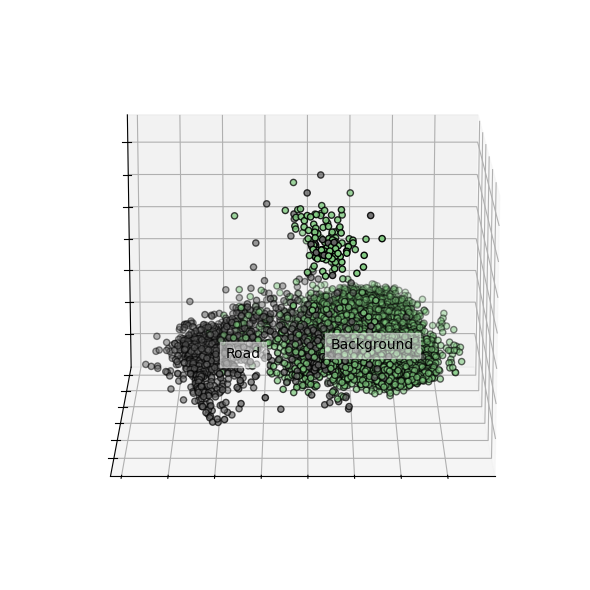

In [21]:
fig = plt.figure(1, figsize=(6, 6))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=15, azim=90)
ax.set_position([0, 0, 0.95, 1])

X = pca_3_comps
y = pca_img_label_cropped.ravel()

for name, label in [("Background", 0), ("Road", 255)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 255]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Accent', edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

There is some clear distinction between the road and backround points but also still a lot of overlap. This shows that the problem of segmenting roads will be difficult but possible.

### K-Means Clustering

Load in test image, this image will be used to test k-Means and future methods

In [23]:
test_image = skio.imread("../data/MA_roads/tiff/train/21929005_15.tiff")
test_image_label = skio.imread("../data/MA_roads/tiff/train_labels/21929005_15.tif")
test_image_label_bool = (test_image_label==255)

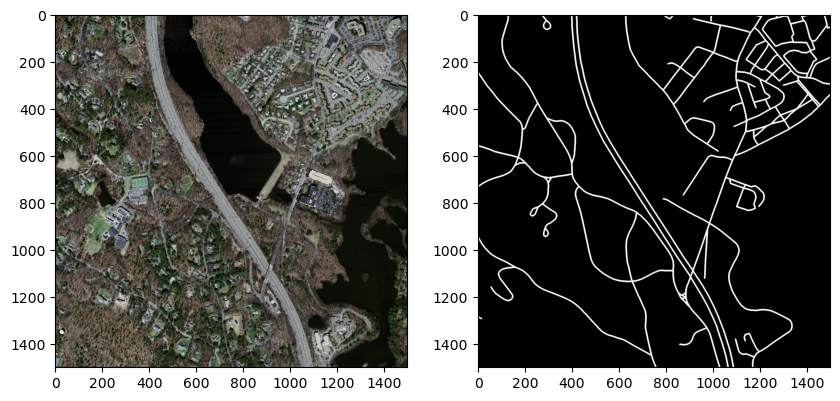

In [24]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(test_image)
axes[1].imshow(test_image_label, cmap='gray')

plt.show()

Get all feature layers and PCA top-5 layers for input into K-Means

In [25]:
test_filters = compute_features(test_image)
test_layers = test_filters.reshape(test_filters.shape[0] * test_filters.shape[1], test_filters.shape[2])

# Standardize the features
test_layers_scaled = scaler.fit_transform(test_layers)

# Initialize PCA and fit the scaled data
test_pca_5 = PCA(n_components=5)
# layers_pca = pca_10.fit_transform(pca_layers_scaled)
test_pca_5_layers = test_pca_5.fit_transform(test_layers_scaled)

Run K-Means on all features

In [26]:
kmeans_all_layers = KMeans(n_clusters=3, verbose=1).fit(test_layers)

Initialization complete
Iteration 0, inertia 156575021617.0.
Iteration 1, inertia 115025038683.5734.
Iteration 2, inertia 112581278537.2893.
Iteration 3, inertia 112197579571.15659.
Iteration 4, inertia 112101897492.05617.
Iteration 5, inertia 112071542003.54475.
Iteration 6, inertia 112060482467.27419.
Iteration 7, inertia 112056114456.59085.
Iteration 8, inertia 112054313068.1214.
Iteration 9, inertia 112053524278.15723.
Iteration 10, inertia 112053178792.97005.
Converged at iteration 10: center shift 0.13958334970474479 within tolerance 0.2913024911899612.


Reshape our segmented image, identify which layer is the layer with the roads, and print metrics

In [27]:
segmented_image_all_layers = kmeans_all_layers.labels_.reshape((test_image.shape[0], test_image.shape[1]))
road_cluster_num = identify_road_cluster(segmented_image_all_layers, test_image_label_bool)
road_cluster = (segmented_image_all_layers==road_cluster_num)
accuracy_metrics(test_image_label_bool.ravel(), road_cluster.ravel())

Confusion matrix:
 [[  96616   43649]
 [ 888145 1221590]]
Overall accuracy: 0.586 
Precision: 0.098 
Recall 0.689 
DICE: 0.172


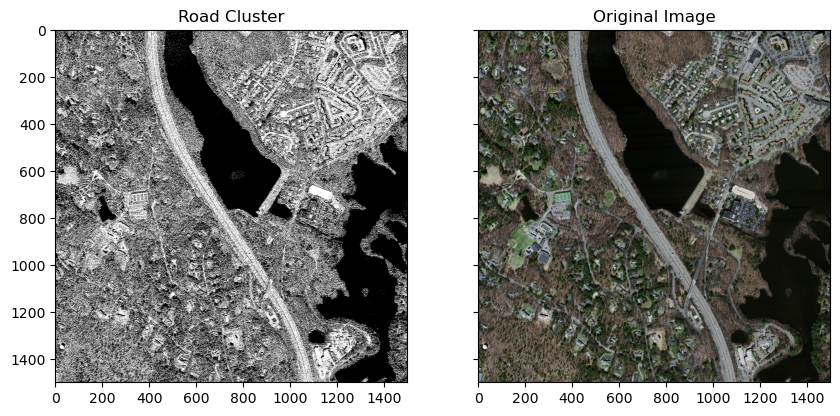

In [28]:
# Show cluster and original image
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

axes[0].imshow(road_cluster, cmap='gray')
axes[0].set_title('Road Cluster')

axes[1].imshow(test_image)
axes[1].set_title('Original Image')

plt.show()

Run K-Means on the PCA filters

In [29]:
kmeans_pca = KMeans(n_clusters=3, verbose=1).fit(test_pca_5_layers)

Initialization complete
Iteration 0, inertia 28462864.121999323.
Iteration 1, inertia 22772599.926497176.
Iteration 2, inertia 22365365.74884916.
Iteration 3, inertia 22305926.751492783.
Iteration 4, inertia 22285522.619277447.
Iteration 5, inertia 22274295.569714464.
Iteration 6, inertia 22267485.489484854.
Iteration 7, inertia 22263139.295963943.
Iteration 8, inertia 22260413.28828707.
Iteration 9, inertia 22258742.78713832.
Iteration 10, inertia 22257703.835843332.
Iteration 11, inertia 22257070.42794912.
Converged at iteration 11: center shift 0.0003099553591653962 within tolerance 0.00041374644497123064.


In [30]:
segmented_image_pca = kmeans_pca.labels_.reshape((test_image.shape[0], test_image.shape[1]))
pca_road_cluster_num = identify_road_cluster(segmented_image_pca, test_image_label_bool)
pca_road_cluster = (segmented_image_pca==pca_road_cluster_num)
accuracy_metrics(test_image_label_bool.ravel(), pca_road_cluster.ravel())

Confusion matrix:
 [[  93505   46760]
 [ 414199 1695536]]
Overall accuracy: 0.795 
Precision: 0.184 
Recall 0.667 
DICE: 0.289


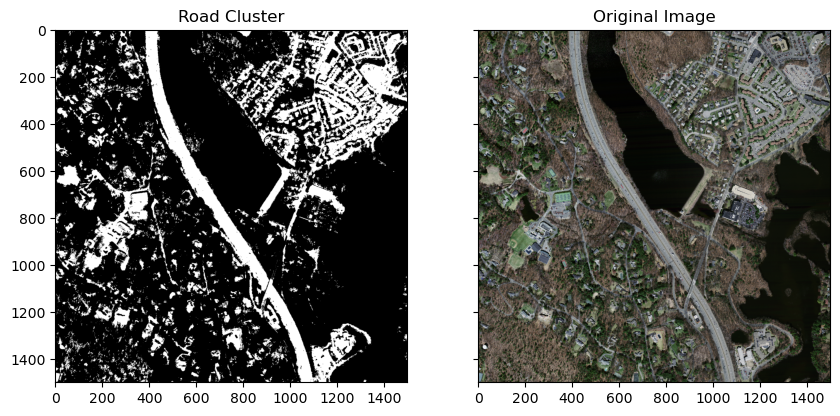

In [31]:
# Show cluster and original image
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

axes[0].imshow(pca_road_cluster, cmap='gray')
axes[0].set_title('Road Cluster')

axes[1].imshow(test_image)
axes[1].set_title('Original Image')

plt.show()

A clear visual difference can be seen with the K-Means clustering run on the PCA top-5 components.
The resulting road clusters are more uniform, while the results with using all features were quite grainy. This observation impacts the metrics as well, with PCA layers having similar recall to all layers but better precision and therefore DICE coefficient.

### Random Forest Results

#### Initial RGB Model

Recall that our initial random forest model uses a small subset of our training image, as displayed earlier.
First, we train our model.

In [32]:
# Flatten images
train_small_rgb = small_rgb.reshape(small_rgb.shape[0]*small_rgb.shape[1], 3)
y_train = small_ans.reshape(small_ans.shape[0]*small_ans.shape[1])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model1 = RF.fit(train_small_rgb, y_train)

# Predictions on training data
model1_pred = model1.predict(train_small_rgb)

# Confusion matrix
accuracy_metrics(y_train, model1_pred)

Confusion matrix:
 [[  8986   4037]
 [  1545 105432]]
Overall accuracy: 0.953 
Precision: 0.853 
Recall 0.69 
DICE: 0.763


While we have a really good overall accuracy rate, we are correctly predicting only 69% of the actual road pixels.
With a precision of 0.85, about 85% of our road predictions are actually roads.

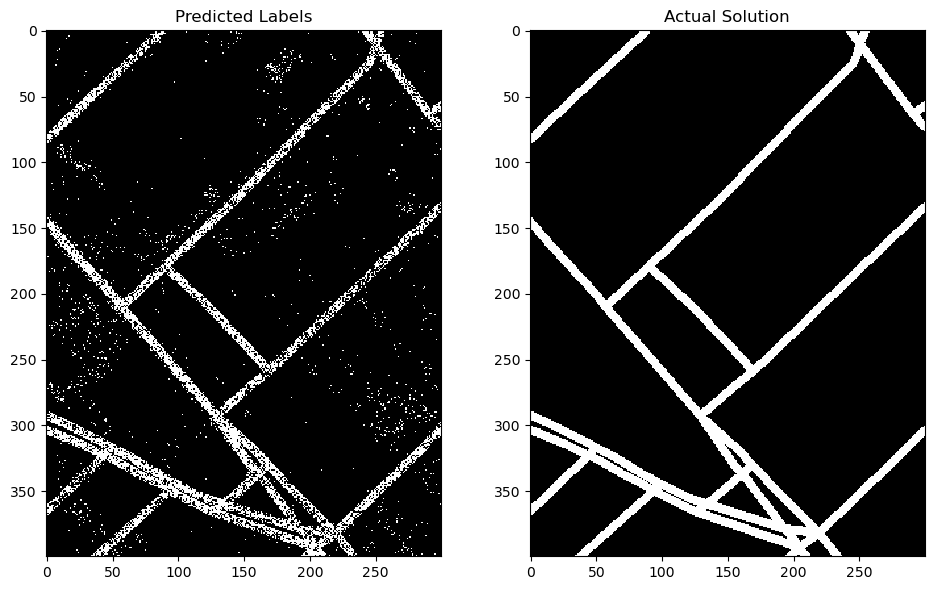

In [33]:
# Convert predictions to image
train_preds = model1_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution");

Visually, our solution looks alright, but it obviously has room for improvement.
Let's see what our results look like on the testing data.

In [34]:
# Flatten images
test_small_rgb = small_rgb_test.reshape(small_rgb_test.shape[0]*small_rgb_test.shape[1], 3)
y_test = small_ans_test.reshape(small_ans_test.shape[0]*small_ans_test.shape[1])

# Predictions on testing data
model1_test_pred = model1.predict(test_small_rgb)

# Confusion matrix
accuracy_metrics(y_test, model1_test_pred)

Confusion matrix:
 [[   605   6498]
 [  4762 108135]]
Overall accuracy: 0.906 
Precision: 0.113 
Recall 0.085 
DICE: 0.097


While we still have a good overall accuracy rate, our predictions of roads is substantially worse.
We have only classified 8.5% of the road pixels correctly, and only 11.3% of our road predictions were actually roads.

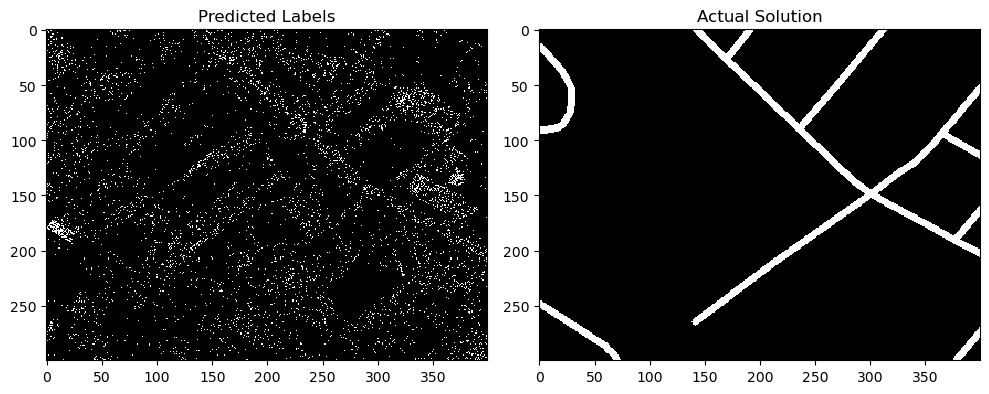

In [35]:
# Convert predictions to image
test_preds = model1_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution");

Our model did NOT generalize well! This looks terrible!

#### Initial Additional Layers Model

Now, let's try training on the same region, but incorporating all of the features described above.

In [36]:
# Train model

# Flatten image
train_small_rgb_layers = small_rgb_layers.reshape(small_rgb_layers.shape[0]*small_rgb_layers.shape[1], small_rgb_layers.shape[2])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model2 = RF.fit(train_small_rgb_layers, y_train)

# Predictions on training data
model2_pred = model2.predict(train_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_train, model2_pred)

Confusion matrix:
 [[ 13023      0]
 [     0 106977]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Now we have virtually perfect results!
Let's look at an image of the output.

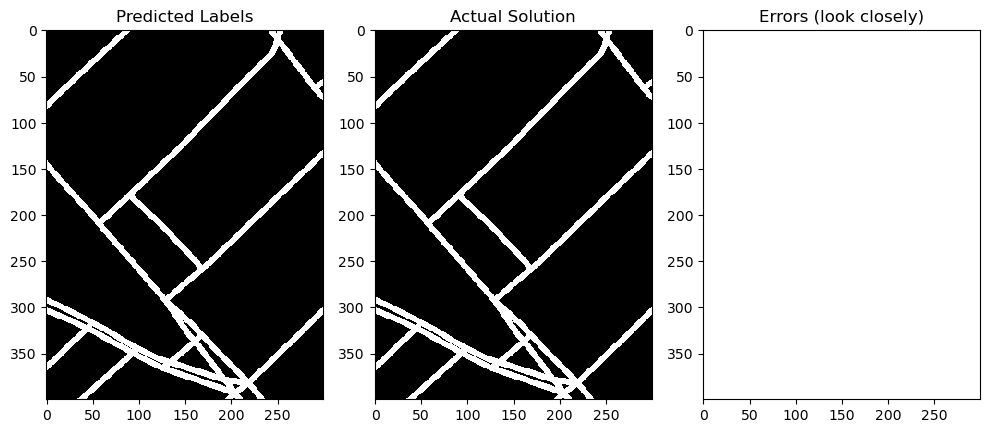

In [37]:
# Convert predictions to image
train_preds = model2_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(train_preds==small_ans, ax = ax[2])
ax[2].set_title("Errors (look closely)");

Yep, can't even find the errors without looking closely at the difference between the two images.
Let's evaluate our results on the testing data!

In [38]:
# Create additional features
small_rgb_test_layers = compute_features(small_rgb_test)

# Flatten image
test_small_rgb_layers = small_rgb_test_layers.reshape(small_rgb_test_layers.shape[0]*small_rgb_test_layers.shape[1], small_rgb_layers.shape[2])

# Predictions on testing data
model2_test_pred = model2.predict(test_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_test, model2_test_pred)

Confusion matrix:
 [[   321   6782]
 [  1839 111058]]
Overall accuracy: 0.928 
Precision: 0.149 
Recall 0.045 
DICE: 0.069


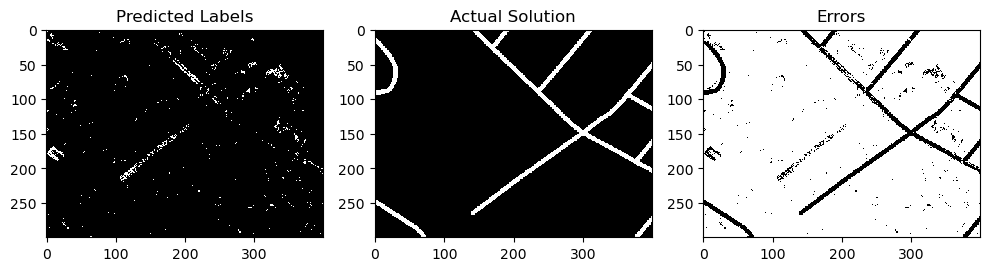

In [39]:
# Convert predictions to image
test_preds = model2_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0], cmap = "gray")
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(test_preds==small_ans_test, ax = ax[2])
ax[2].set_title("Errors");

Adding these filters to our model had negligible impact on our results.
It improved the accuracy from 0.906 to 0.928 and the precision from 0.113 to 0.149, but the recall dropped from 0.085 to 0.045.
This means that of the pixels that actually represent roads, we are only correctly classifying 4.7% of them.
With perfect results on our training data and pitiful results on our testing data, it appears that incorporating these features in our training data led to severe overfitting!
Visually, our results look slightly less random, even though the performance metrics are worse.

#### Sampling for Overfitting: RGB

We have fed a substantial amount of data, which ought to contain some useful information regarding roads, to our model
In our training solution, this data was in fact useful, leading to virtually 100% accuracy.
However, on the testing data for both the RGB model and the model with additional layers, our model correctly predicted less than 10% of our roads.
Perhaps this means that our model is overfit to our training data.
Since the vast majority of pixels in our training data represent non-roads, perhaps our model is overfit to the particularities of the non-road pixels in our training data.
One way to address this issue is to randomly select an equal number of pixels of both classes, and then train the model on those pixels.
Let's try randomly picking 5000 road pixels and 5000 non-road pixels for our training data and 5000 of each for our testing data and evaluating our model's performance.

First, let's use this method on a model with just RGB layers.

In [40]:
# Flatten training images
train_rgb = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
y_train = ans.reshape(ans.shape[0]*ans.shape[1])

# Subset training data by label
y_train_true = y_train[y_train]
y_train_false = y_train[~y_train]
train_rgb_true = train_rgb[y_train]
train_rgb_false = train_rgb[~y_train]

# Sample indices of each label
true_indices = sample_without_replacement(y_train_true.shape[0], 10000)
false_indices = sample_without_replacement(y_train_false.shape[0], 10000)

# Create modified training data
y_train_mod = np.concatenate([y_train_true[true_indices[:5000]], y_train_false[false_indices[:5000]]])
train_rgb_mod = np.concatenate([train_rgb_true[true_indices[:5000]], train_rgb_false[false_indices[:5000]]])

# Create modified testing data
y_test_mod = np.concatenate([y_train_true[true_indices[5000:]], y_train_false[false_indices[5000:]]])
test_rgb_mod = np.concatenate([train_rgb_true[true_indices[5000:]], train_rgb_false[false_indices[5000:]]])

In [41]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model3 = RF.fit(train_rgb_mod, y_train_mod)

# Predictions on training data
model3_pred = model3.predict(train_rgb_mod)

# Confusion matrix
accuracy_metrics(y_train_mod, model3_pred)

Confusion matrix:
 [[4960   40]
 [  73 4927]]
Overall accuracy: 0.989 
Precision: 0.985 
Recall 0.992 
DICE: 0.989


While this model does not have 100% training accuracy like the additional layers model, it has improved significantly over the original RGB model.
Most notably, the training recall has improved from less than 70% to roughly 99%.
Let's see if we maintain this performance when we make predictions on our testing data.

In [42]:
# Predictions on testing data
model3_test_pred = model3.predict(test_rgb_mod)

# Confusion matrix
accuracy_metrics(y_test_mod, model3_test_pred)

Confusion matrix:
 [[3794 1206]
 [1267 3733]]
Overall accuracy: 0.753 
Precision: 0.75 
Recall 0.759 
DICE: 0.754


Our results are encouraging!
Our overall accuracy, precision, and recall are all approximatly 0.75.
In the original RGB model, the overall accuracy was over 90%, while the precision and recall were roughly 10%.
By balancing the amount of training data in each class, we were able to balance the different accuracy metrics, improving our predictions of roads at the expense of our predictions of non-roads.
Perhaps if we incorporate our additional layers into the model, these balance improvements will translate to balanced and higher accuracy metrics. 

While our results above are encouraging, our training and testing data were both drawn from the same image, so our model may have overtrained to this image.
Let's form predictions and compute accuracy metrics on a different image.

In [43]:
# Flatten testing images
flat_rgb_test = rgb_test.reshape(rgb_test.shape[0]*rgb_test.shape[1], 3)
y_test = ans_test.reshape(ans_test.shape[0]*ans_test.shape[1])

# Predictions on testing data
model3_test_pred_2 = model3.predict(flat_rgb_test)

# Confusion matrix
accuracy_metrics(y_test, model3_test_pred_2)

Confusion matrix:
 [[ 100346   39919]
 [ 344802 1764933]]
Overall accuracy: 0.829 
Precision: 0.225 
Recall 0.715 
DICE: 0.343


Surprisingly, the overall accuracy is higher in the testing image than in the training image!
The recall is still over 70%, indicating that we are capturing most pixels representing roads correctly.
With a much lower precision, we must be predicting road pixels frequently where there are not actually roads.

Since we are working with an entire image, we can inspect our results!

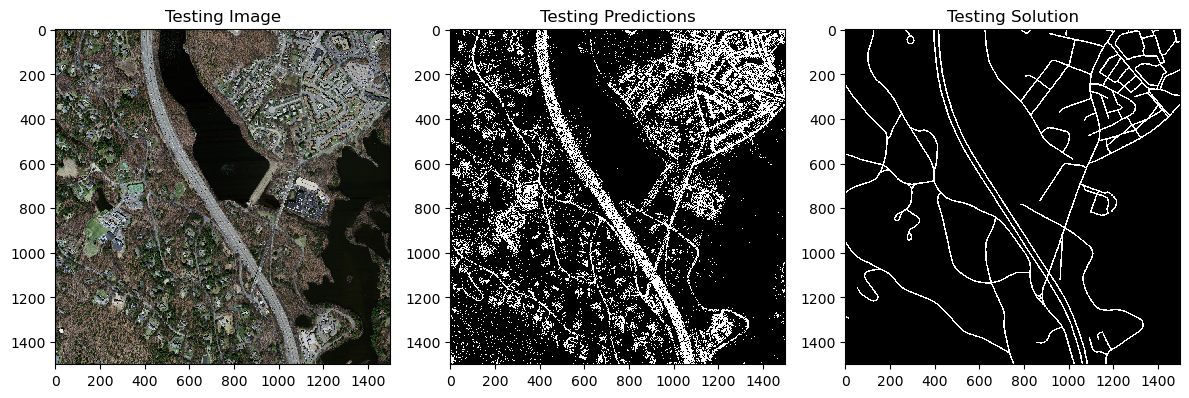

In [44]:
# Convert predictions to image
test_preds = model3_test_pred_2.reshape(rgb_test.shape[0], rgb_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

It looks like we tend to label pixels as roads when they in reality represent other human features like buildings.
We also exaggerate the width of some roads.

#### Sampling for Overfitting: Additional Layers

Now let's try the same sampling technique but after producing all of our features.

In [45]:
# Create additional features
train_rgb_mod_layers = compute_features(rgb)

# Flatten training image with extra layers
train_rgb_2 = train_rgb_mod_layers.reshape(train_rgb_mod_layers.shape[0]*train_rgb_mod_layers.shape[1], train_rgb_mod_layers.shape[2])

# Subset training data by label
train_rgb_true_2 = train_rgb_2[y_train]
train_rgb_false_2 = train_rgb_2[~y_train]

# Create modified training data
train_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[:5000]], train_rgb_false_2[false_indices[:5000]]])

# Create modified testing data
test_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[5000:]], train_rgb_false_2[false_indices[5000:]]])

In [46]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model4 = RF.fit(train_rgb_mod_2, y_train_mod)

# Predictions on training data
model4_pred = model4.predict(train_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_train_mod, model4_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Our training results are literally perfect.
Does this translate to our testing data?

In [47]:
# Predictions on testing data
model4_test_pred = model4.predict(test_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_test_mod, model4_test_pred)

Confusion matrix:
 [[4102  898]
 [1062 3938]]
Overall accuracy: 0.804 
Precision: 0.794 
Recall 0.82 
DICE: 0.807


It appears that there were some errors on our testing data.
Going from the RGB model to the additional layers model, our overall accuracy improved from 0.755 to 0.812, the precision improved from 0.749 to 0.796, and the recall improved from 0.767 to 0.84.
These are the most accurate road predictions yet!

While our training and testing data contained none of the same pixels, they were both drawn from the same image, so it is possible that they were overtrained to our particular image of choice.
Perhaps a more valid testing metric would involve testing our model on pixels from a different image.
Let's form predictions and compute accuracy metrics on the entirety of another image.

In [48]:
# Create additional features
test_rgb_layers_3 = compute_features(rgb_test)

# Flatten testing images
test_rgb_3 = test_rgb_layers_3.reshape(test_rgb_layers_3.shape[0]*test_rgb_layers_3.shape[1], test_rgb_layers_3.shape[2])

In [49]:
# Predictions on testing data
model4_test_pred_2 = model4.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model4_test_pred_2)

Confusion matrix:
 [[  92296   47969]
 [ 249036 1860699]]
Overall accuracy: 0.868 
Precision: 0.27 
Recall 0.658 
DICE: 0.383


Similar to the RGB model, the results on the testing image were largely similar to the results on the previous image, except for the precision dropping by over 50%
The overall accuracy is over 85%, but the recall is now 65.9% and the precision is now 26.6%.
While this is certainly not perfect, the precision and recall are still a substantial improvement over the models without sampling.
However, the recall was actually slightly higher in the sampled RGB model, indicating that the RGB model generalized better in terms of predicting road pixels.
Perhaps there are tactics we can use to combat overfitting.

Also, since we are now working with a complete image, we can once again inspect a full image illustrating our predictions versus the truth.

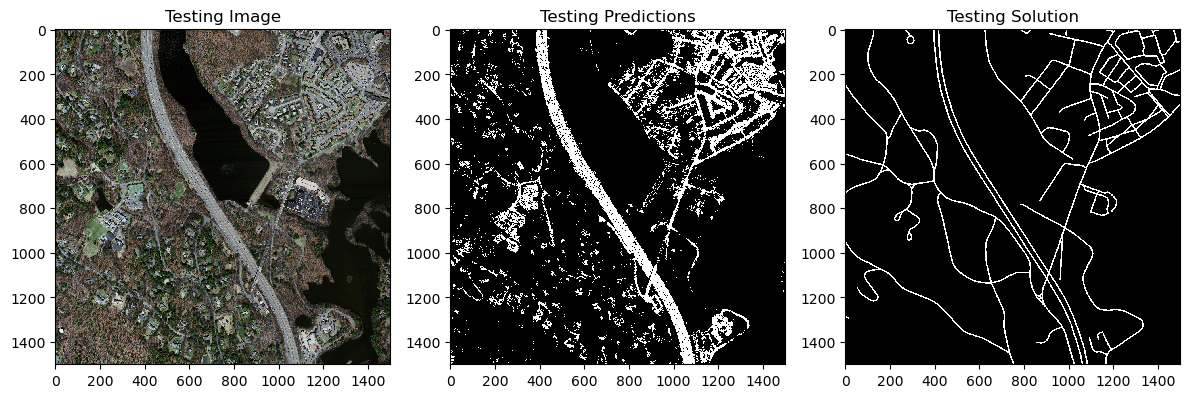

In [50]:
# Convert predictions to image
test_preds = model4_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

Once again, our model tends to incorrectly predict roads where there are other human features like buildings, and it exaggerates the width of some roads.

#### PCA for Overfitting

It appears that our additional layers model with sampled training data is overfit to our training data, as we have excellent performance on the training data but subpar performance on the new image.
Perhaps our model suffers from overfitting because we have constructed so many features, many of which are similar to one another.
To help combat this issue, we fit our model again below, but after applying Principal Component Analysis and selecting the most important components.

First, we apply Principal Component Analysis to our training data and plot the percent variance explained by each component.
Note that PCA is only applicable for continuous features, so we cannot include binary features such as canny edges in this model.

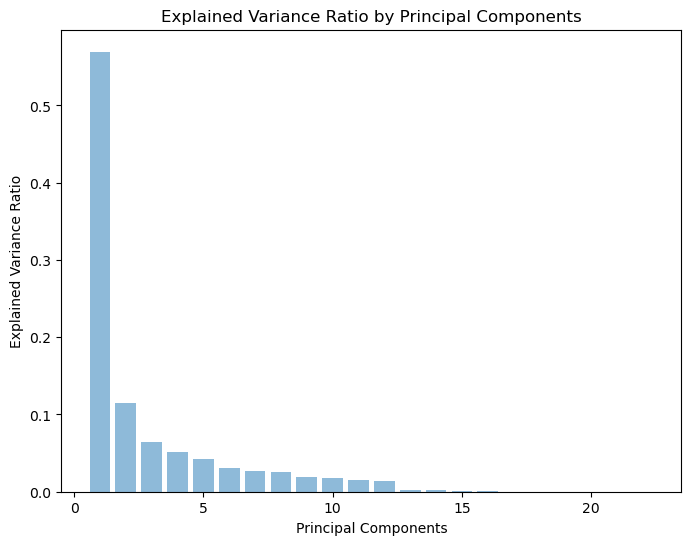

In [51]:
# Add layers to model
train_pca_layers = compute_features(rgb, include_categorical = False)   

# Flatten training image with extra layers
train_pca_layers_flat = train_pca_layers.reshape(train_pca_layers.shape[0]*train_pca_layers.shape[1], train_pca_layers.shape[2])

# Standardize the features
scaler = StandardScaler()
train_pca_layers_scaled = scaler.fit_transform(train_pca_layers_flat)

# Initialize PCA and fit the scaled data
pca = PCA(n_components=train_pca_layers.shape[2])
layers_pca = pca.fit_transform(train_pca_layers_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

Apparently, over 50% of the variance in our data can be explained by the first component!
The second component only accounts for about 11.5% of the variance in the data, and the numbers continue to drop after that.

In [52]:
explained_variance_ratio[0:5].sum()

0.843420909342875

The first 5 components account for over 84% of the variation in our data.
Let's try only retaining the first 5 components for our model and seeing whether our performance improves.

In [53]:
# Initialize PCA and fit the scaled data
pca = PCA(n_components=5)
layers_pca = pca.fit_transform(train_pca_layers_scaled)

# Subset training data by label
layers_pca_true = layers_pca[y_train]
layers_pca_false = layers_pca[~y_train]

# Create modified training data
layers_pca_mod_train = np.concatenate([layers_pca_true[true_indices[:5000]], layers_pca_false[false_indices[:5000]]])

# Create modified testing data
layers_pca_mod_test = np.concatenate([layers_pca_true[true_indices[5000:]], layers_pca_false[false_indices[5000:]]])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model5 = RF.fit(layers_pca_mod_train, y_train_mod)

# Predictions on training data
model5_pred = model5.predict(layers_pca_mod_train)

# Confusion matrix
accuracy_metrics(y_train_mod, model5_pred)

Confusion matrix:
 [[4999    1]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Per usual with our additional layers, our model's performance is virtually perfect on the training data.
Let's take a look at the testing performance.

In [54]:
# Predictions on testing data
model5_test_pred = model5.predict(layers_pca_mod_test)

# Confusion matrix
accuracy_metrics(y_test_mod, model5_test_pred)

Confusion matrix:
 [[3820 1180]
 [1379 3621]]
Overall accuracy: 0.744 
Precision: 0.735 
Recall 0.764 
DICE: 0.749


On the testing data, all of our model's performance metrics are lower than its non-PCA counterpart, although not by that much.
Let's test on an entirely new image.

In [55]:
# Add layers to model
test_pca_layers = compute_features(rgb_test, include_categorical = False)

# Flatten testing images
test_pca_layers_flat = test_pca_layers.reshape(test_pca_layers.shape[0]*test_pca_layers.shape[1], 22)

# Standardize the features
test_pca_layers_scaled = scaler.fit_transform(test_pca_layers_flat)

# Project onto principal components
layers_pca_test = pca.transform(test_pca_layers_scaled)

In [56]:
# Predictions on testing data
model5_test_pred_2 = model5.predict(layers_pca_test)

# Confusion matrix
accuracy_metrics(y_test, model5_test_pred_2)

Confusion matrix:
 [[  75268   64997]
 [ 536637 1573098]]
Overall accuracy: 0.733 
Precision: 0.123 
Recall 0.537 
DICE: 0.2


Again, on the testing image, all of our model's performance metrics are lower than its non-PCA counterpart.
In this scenario, it appears that the components explaining very little variation in the data were actually somewhat useful for predictions.
Note that we tried this with a variety of number of retained components, and we found that the model's performance improved as we increased the number of components.

Below, we inspect the image of our predictions.

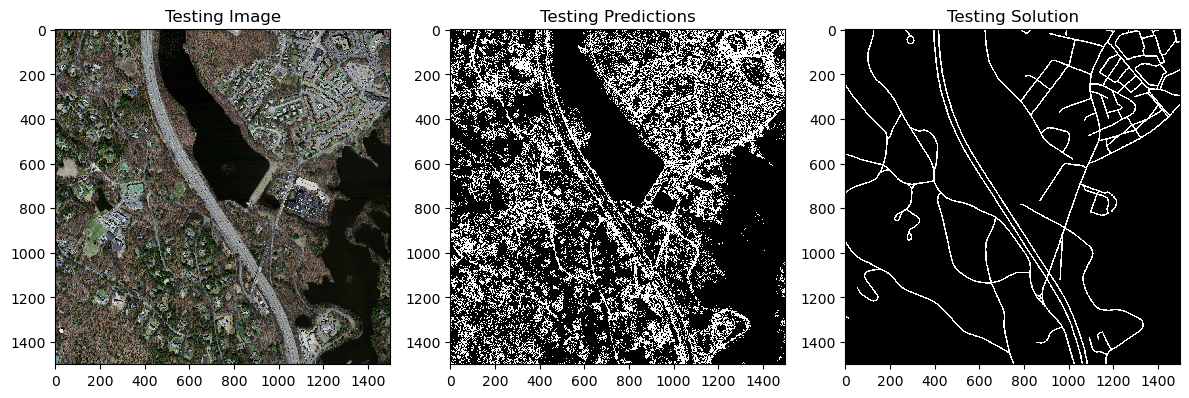

In [57]:
# Convert predictions to image
test_preds = model5_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

Visually, our predictions appear somewhat worse that those from our non-PCA additional layers model.
There is overall a lot more noise in our predictions, and interestingly, we are not predicting a road in much of the massive highway.

#### Sampling from Multiple Images: RGB

PCA did not help us generalize to new testing data, but perhaps there is another approach we could take.
Earlier, we created our training data by sampling from a single image.
Perhaps we could sample from multiple images, mitigating bias from working with a single image.
Below, we select 10 images and sample from them to train our model.

In [59]:
# Store id's of images
imgs = ["10828735_15", "10228675_15", "10228705_15", "10228720_15", "10228735_15", "10528675_15", "10528750_15", "10978720_15", "11128825_15", "12028750_15"]

# Initialize arrays to store training data
y_train = np.array([])
rgb_train = np.zeros((0,3))

# Sample from each image
for img in imgs:
    rgb = skio.imread("../data/MA_roads/tiff/train/" + img + ".tiff")
    ans = skio.imread("../data/MA_roads/tiff/train_labels/" + img + ".tif") > 0
    
    # Flatten training images
    rgb_flat = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
    ans_flat = ans.reshape(ans.shape[0]*ans.shape[1])
    
    # Subset training data by label
    ans_true = ans_flat[ans_flat]
    ans_false = ans_flat[~ans_flat]
    rgb_true = rgb_flat[ans_flat]
    rgb_false = rgb_flat[~ans_flat]
    
    # Sample indices of each label
    true_indices = sample_without_replacement(ans_true.shape[0], 5000)
    false_indices = sample_without_replacement(ans_false.shape[0], 5000)
    
    # Create modified training data
    y_train = np.concatenate([y_train, ans_true[true_indices], ans_false[false_indices]])
    rgb_train = np.concatenate([rgb_train, rgb_true[true_indices], rgb_false[false_indices]])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model6 = RF.fit(rgb_train, y_train)

# Predictions on training data
model6_pred = model6.predict(rgb_train)

# Confusion matrix
accuracy_metrics(y_train, model6_pred)

Confusion matrix:
 [[48194  1806]
 [ 2559 47441]]
Overall accuracy: 0.956 
Precision: 0.95 
Recall 0.964 
DICE: 0.957


These metrics are actually somewhat lower than the training metrics for the RGB model sampled from a single image.
But our true question is whether the model generalizes better to the testing data -- more specifically, to our new testing image.

In [60]:
# Predictions on testing data
model6_test_pred = model6.predict(flat_rgb_test)

# Confusion matrix
accuracy_metrics(y_test, model6_test_pred)

Confusion matrix:
 [[ 110650   29615]
 [ 384361 1725374]]
Overall accuracy: 0.816 
Precision: 0.224 
Recall 0.789 
DICE: 0.348


In the RGB model trained on sampling data from one image, our results were as follows.

- Overall accuracy: 0.829 
- Precision: 0.225 
- Recall 0.715 
- DICE: 0.343

This model has slightly decreased in all metrics except for the recall.
Considering the additional computational power required to train this model, it does not appear to be advantageous over the other model.

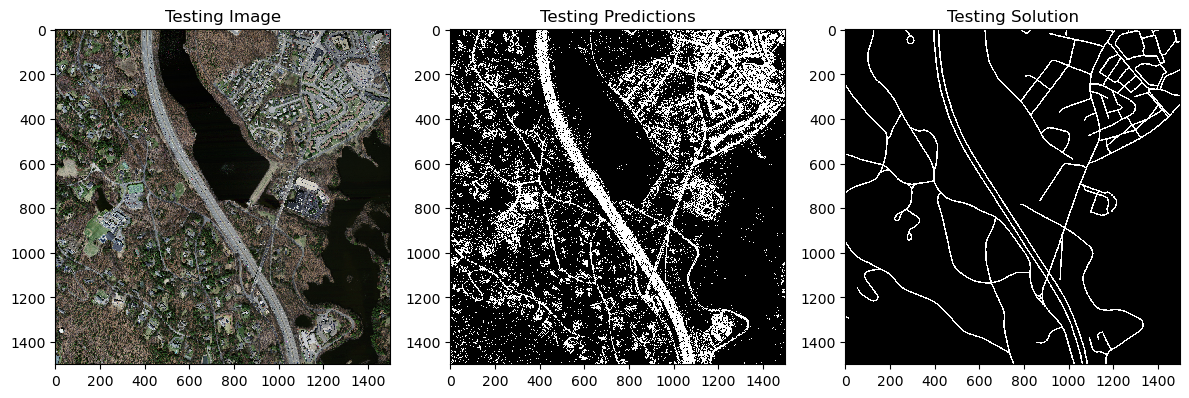

In [61]:
# Convert predictions to image
test_preds = model6_test_pred.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

The output image visually looks quite similar to that when trained on data sampled from a single image.

#### Sampling from Multiple Images: Additional Layers

First, we train our model.

In [64]:
# Store id's of images
imgs = ["10828735_15", "10228675_15", "10228705_15", "10228720_15", "10228735_15", "10528675_15", "10528750_15", "10978720_15", "11128825_15", "12028750_15"]

# Initialize arrays to store training data
y_train = np.array([])
rgb_train = np.zeros((0,27))

# Sample from each image
for img in imgs:
    rgb = skio.imread("../data/MA_roads/tiff/train/" + img + ".tiff")
    ans = skio.imread("../data/MA_roads/tiff/train_labels/" + img + ".tif") > 0

    # Create additional layers
    rgb_layers = compute_features(rgb)
    
    # Flatten training images
    rgb_flat = rgb_layers.reshape(rgb_layers.shape[0]*rgb_layers.shape[1], rgb_layers.shape[2])
    ans_flat = ans.reshape(ans.shape[0]*ans.shape[1])
    
    # Subset training data by label
    ans_true = ans_flat[ans_flat]
    ans_false = ans_flat[~ans_flat]
    rgb_true = rgb_flat[ans_flat]
    rgb_false = rgb_flat[~ans_flat]
    
    # Sample indices of each label
    true_indices = sample_without_replacement(ans_true.shape[0], 5000)
    false_indices = sample_without_replacement(ans_false.shape[0], 5000)
    
    # Create modified training data
    y_train = np.concatenate([y_train, ans_true[true_indices], ans_false[false_indices]])
    rgb_train = np.concatenate([rgb_train, rgb_true[true_indices], rgb_false[false_indices]])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model7 = RF.fit(rgb_train, y_train)

# Predictions on training data
model7_pred = model7.predict(rgb_train)

# Confusion matrix
accuracy_metrics(y_train, model7_pred)

Confusion matrix:
 [[49999     1]
 [    1 49999]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Per usual when working with all of our layers, we have virtually perfect results on our training data.
Next, we test the model on our usual testing image.

In [65]:
# Predictions on testing data
model7_test_pred = model7.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model7_test_pred)

Confusion matrix:
 [[ 115371   24894]
 [ 321743 1787992]]
Overall accuracy: 0.846 
Precision: 0.264 
Recall 0.823 
DICE: 0.4


This is the best performance we have seen so far.
The biggest difference between this model and the additional layers model with training data sampled from a single image is that the recall has increased from 0.658 to 0.823.

Finally, we visually inspect our output.

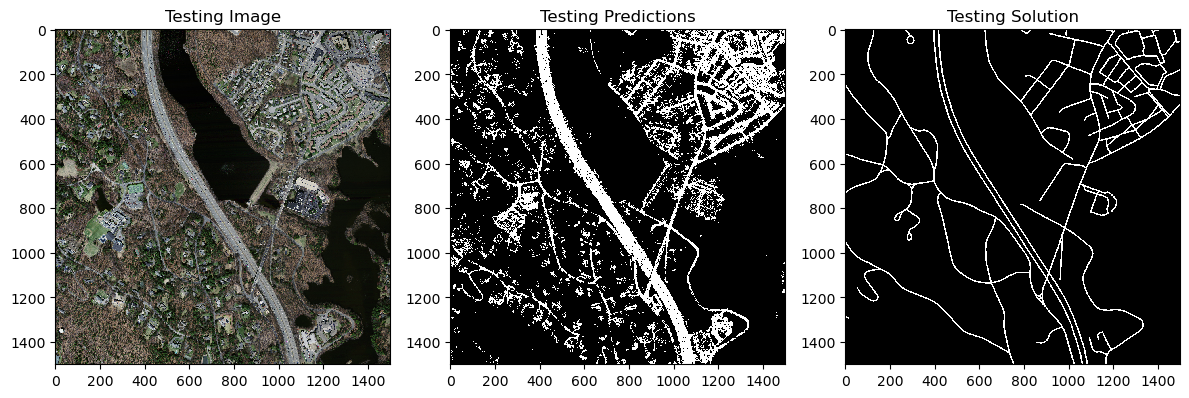

In [66]:
# Convert predictions to image
test_preds = model7_test_pred.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

This is definitely the cleanest output we have seen so far, which is reflective of our model's high recall value.
The model continues to erroneously label human features that are not roads as roads, and it has labelled virtually the entire highway as road instead of just its centerlines.
Differentiating between the centerline and the road surface seems to be a very difficult problem.

#### Comparison of Random Forest Results

We fit a lot of random forest models, so we summarized their accuracy metrics in the following table.
Note that our testing metrics listed here are the results when we tested on an entirely new image.

| Model              | RGB | More Layers | RGB Sampled | More Layers Sampled | PCA Sampled | RGB Multiple Images | More Layers Multiple Images |
| :----------------: | :----: | :----: | :----: | :----: | :----: |  :----: |  :----: |
| **Training Accuracy** |   0.953   | 1.0 | 0.989    | 1.0 | 1.0 | 0.956 | 1.0|
| **Training Precision** |   0.853    | 1.0 | 0.985    | 1.0| 1.0 |0.95 |1.0|
| **Training Recall** |  0.69    | 1.0 | 0.992    | 1.0 |1.0 |0.964 |1.0|
| **Training Dice** |  0.763   | 1.0 | 0.989   |  1.0|1.0 |0.957|1.0|
| **Testing Accuracy** |   0.906 | 0.928 | 0.829    | 0.868  | 0.733|0.816 | 0.846 |
| **Testing Precision** |   0.113    | 0.149 |  0.225    | 0.27  |0.123 |0.224 | 0.264 |
| **Testing Recall** |  0.085    | 0.045 |  0.715    | 0.658 |0.537 |0.789 |  0.823 |
| **Testing Dice** |  0.097   |  0.069 | 0.343   | 0.383 |0.2|0.348| 0.4|

For a quick summary of each model's performance, we look at the testing Dice score.
We noticed a major bump in performance when we started sampling equal portions of training data, with the dice coefficient of both the RGB and additional layers models jumping from less than 0.1 to above 0.3.
We attempted to account for overfitting by introducing PCA, but this cut our Dice coefficient in half.
Finally, creating our training data by sampling from multiple images resulted in the highest performance, particularly in the additional layers model, where the Dice coefficient jumped to 0.4.
Our final model was our best performing random forest model by every metric except testing accuracy.

### U-Net Results

Because of the high computational demans of the U-Net model, we did not re-run the model in this notebook.
For full documentation of our code, please see our [GitHub repository](https://github.com/Liam-W-Smith/csci-0452-final-project).

We managed to get solid predictions for the small 128 x 128 images. The precision got up to 0.445, the recall went to 0.938, and the dice coefficient was 0.604. We wanted to compare our results with the previous models, so we ran our predictions on the test set (also divided into 128 x 128 pixel images), and reconstructed the 128 x 128 masks to get 1408 x 1408 masks which resemble the original image. These final predictions were less accurate than the original 128 x 128 masks with a precision metric of 0.06, a recall of 0.197, and a dice coefficient of 0.092. Individually the predictions made by the U-Net were pretty accurate, but when reconstructed to the greater original image size, the cumulative prediction must have lost enough information to lower its accuracy metrics. 


### Overall Result Comparison

Which method worked best: k-means, random forest, or U-Net? We include the following table to facilitate comparison of results.
We trained many different models in the preceding sections, but we only report the best performing model for each method in the table below.

| Model    | K-Means | Random Forest | U-Net |
| :----------------: | :----: | :----: | :----: 
| **Testing Precision** | 0.187 |  0.264 | 0.06 |
| **Testing Recall** | 0.661 | 0.823 | 0.197 |
| **Testing Dice** | 0.291| 0.4| 0.092 |

Essentially, with increasing complexity of the algorithm and computational requirements came increased performance.
K-Means clustering required the least computational power but also achieved the worst results, achieving a Dice coefficient of 0.291 after we reduced the number of features using PCA. 
Random forest required more computational power, especially when we began sampling training data from multiple images, achieving an improved Dice score of 0.4.
Finally, our U-Net model achieved even better results when we considered small subsets of our testing images with a dice score of 0.604, but poor results when applied to the entire image with a Dice score of 0.092.
The U-Net models in the literature and Kaggle datasets have achieved by far the best results.
Unfortunately, achieving such high performance with U-Net requires substantial computational power for model training.
Overall, we conclude that U-Net can achieve the best performance when appropriate resources are available.
In the absence of high performance computing capabilities, random forest may suffice.

## Discussion

We had mixed results with the effectiveness of PCA. For K-Means Clustering, using the top-5 components helped the model perform better but for Random Forest, using PCA did not improve the results. PCA was not applicable to deep neural networks so we cannot make a firm conclusion on whether or not PCA is an important tool for segmenting road with satellite images.

ADD MORE

Althogh U-Net was very expensive computationally and took the most time to run, we conclude that it is the best approach of the three we tested. This methodology will often be applied to very large datasets and will had high computational requirements just because of the amount of data. Also high precision and recall are very important if the benefits from segmenting roads is to be maximized. 

## Accessibility

Due the high requirements to run these models, especially U-Net, and the large amount of data needed, these methods are not very accessible to many individuals. Luckily this is not a task that many individuals would look to perform but more a task that would be performed by large organization like governments. Considering accessibility at this scale brings in the question of access to large datasets and high performance computers, as many countries may not have access to such resources and therefore would not be able to implement these methods on a large scale.

There are some positive accessibility points with these algorithms as well, being that no one has to physically be in the place where you hope to segment roads. This means that in areas with difficult to access roads, one can still segment the road network. Some examples of when this could be extremely helpful are climate disasters and war time aid. With climate disasters, roads may be destroyed like during the floods in Vermont last summer. Knowing what roads were destroyed without having to go out into the field where danger from flood is still high could be extremely helpful for disaster response. In the example of war, especially in places that are being heavily bombed, it may be hard to get humanitarian aid workers into certain areas due to the destruction of roads. These algorithms could help assess with roads are still open without having to put anyone on the field and in danger.

There are some other accessibility points such as ability to interpret the image segmentation. In an area where the visual interpretation is essential, making sure color blind inclusive colors are used is very important.

## Ethical Considerations

As mentioned above, some countries and organizations may not have the resources to train large models like U-Net. Resources like data centers and HPCs are essential and many places may not have access to them. Looking deeper, if a country like the US trains a UNet model for segmenting roads on a dataset including road in the US, that model could be used by other countries but it may be much less accurate if there road infrastructure looks different than that in the US. Furthermore, if large labeled datasets of roads only exist with roads from developed countries, this would hinder any country that may have less built infrastructure as the training data will not align with the data being input into the model.


Further ethical considerations around data across fields is the exploitative nature in which many labeled datasets are created. Large tech companies often out-source their data labeling overseas and pay people very little for the data that makes all this possible. They make huge profits off of the models that are only possible with this labeled data and the associated labor.


Going into remote sensing and the high resolution of satellite images, privacy concerns may be raised. These satellite images will contain sections consisting of private problems and invasion of personal privacy should always be a consideration when using remote sensing on inhabited areas.


## Reflection

### Schedule and Obstacles

We each stayed on schedule for our tasks in general, but some tasks were much more difficult than expected and we ended up deciding we would save them for future work. Some tasks just ended up being more time consuming, like training the U-Net. Lots of time was spent waiting for a model to train just have an error or horrible predictions. Looking back, we should have learned how to connect to Middlebury's ADA cluster to train our model. We ended up ditching LiDAR data because it was more difficult to process than we realized and would put an even heavily burden on the amount of training data we were using. We also felt like we already had a plethora of topics to discuss and compare, so it wasn't necessary to add even another aspect to the project.

### Future Work

Future work we are interested in pursuing is of course integrating LiDAR data into each of our models and comparing the metrics on how well roads were segmented. We are very curious to see if this additional data would help our models and are interested in learning about LiDAR data. Another path of future work is performing more data engineering and augmentation on our training data for input into U-Net. We know from reading and seeing models trained on Kaggle that very accurate segmentations are possible and we had a lot of room for improvement with our model.